In [9]:
#from src.utils.builder import build_trainer, build_config
from src.utils.utils import *
from src.utils.builder import *
from src.utils.fileio import *
from src.common.registry import registry
from arguments import args
from time import time
from PIL import Image
import numpy as np
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from tqdm import tqdm 

# --------------- Import Dataset Builder function -----------------
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.cityscapes_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.kitti_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.falling_things_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.sceneflow_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.sintel_stereo_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.tartan_air_dataset import *

from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.kitti_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.falling_things_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.sceneflow_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.sintel_stereo_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.tartan_air_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.eth3d_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.middlebury_dataset import *

from src.datasets.dataset_zoo.stereo_vision_mim.stereo_vision_mim_builder import StereoVisionMaskedImageModellingDatasetModule

global TESTING 
TESTING = "downstream" # either 'downstream' or 'mim'


# Defining helper functions

In [2]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
def get_transforms(config, split):
    transforms_name = config.dataset_config.preprocess.name
    data_transform_cls = registry.get_preprocessor_class(transforms_name)
    data_transforms_obj = data_transform_cls(config, split)
    return data_transforms_obj

def ToArray(img_t):
    img = img_t.detach().to("cpu").numpy()
    img = np.transpose(img, (1, 2, 0))

    return img

# Standard input arguments (config paths)

In [3]:
class Args:
    default_config_path= './configs/default.yaml'
    model_config_path='./configs/models/masked_image.yaml'
    if TESTING=='downstream':
        dataset_config_path='./configs/datasets/stereo_downstream.yaml'
    else:
        dataset_config_path='./configs/datasets/stereo_mim.yaml'
    user_config_path='./configs/user/sample.yaml'
    local_rank=None
    opts=None

args=Args()

# File IO functions initialised

In [4]:
# --------------- configure initialisers -----------------
setup_imports()

config = build_config(args)

# setup aws env variables:
fileio_client = FileIOClient(config)

# check correct config loaded;
print(config.dataset_config.dataset_name)
#print(config.dataset_config.usable_columns)

Global seed set to 42424242


THIS VERSION OF THE CODE SUPPORTS LOCAL FILE I/O ONLY! FOR CLOUD CLIENTS CONTACT THE MAINTAINER
output dir for saving files: "/data/samyakhtukra/mim/mae_stereo_test/230209-190448/train_outputs" created!
stereo_mim


# Define dataset transforms

In [5]:
train_transforms = get_transforms(config, 'train')
test_transforms = get_transforms(config, 'test')

/opt/venv/lib/python3.7/site-packages/torchvision/transforms/transforms.py:900: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [ ]:
def augmentation_parameters(config):
    dataset_config = config.dataset_config
    preprocess_config = dataset_config.preprocess.vision_transforms.params
    aug_params = {'crop_size': preprocess_config.Resize.size, 'min_scale': preprocess_config.spatial_scale[0], 'max_scale': preprocess_config.spatial_scale[1], 'do_flip': preprocess_config.do_flip, 'yjitter': not preprocess_config.noyjitter}
    
    if hasattr(preprocess_config, "saturation_range") and preprocess_config.saturation_range is not None:
        aug_params["saturation_range"] = tuple(preprocess_config.saturation_range)
    
    if hasattr(preprocess_config, "img_gamma") and preprocess_config.img_gamma is not None:
        aug_params["gamma"] = preprocess_config.img_gamma
    
    if hasattr(preprocess_config, "do_flip") and preprocess_config.do_flip is not None:
        aug_params["do_flip"] = preprocess_config.do_flip
    return aug_params


# Define dataset class

In [6]:
# -------------- Initialise dataset -----------------
if TESTING=='downstream':
    aug_params = augmentation_parameters(config)
    train_dataset = SceneFlowDatasetsClean(config = config, aug_params = aug_params, split='train')
    val_dataset = SceneFlowDatasetsClean(config = config, aug_params = aug_params, split='val')
else:
    train_dataset = SceneFlowLoader(config, 'train', train_transforms)
    val_dataset = SceneFlowLoader(config, 'val', train_transforms)

# iterate over the dataset
print('no. training # samples: {}'.format(len(train_dataset)))
print('no. val # samples: {}'.format(len(val_dataset)))

no. training # samples: 40262
no. val # samples: 2120


# Test file name compatibility

In [ ]:
if TESTING=='downstream':
    for i in tqdm(range(len(train_dataset))):
        #if i > 0:
        #    break
        #else:
        # left_image, right_image = dataset[i]
        sample = train_dataset[i]
        image_disp_path_list, left_img, right_img, disp, valid = sample
        left_idx = image_disp_path_list[0][78:-4]
        right_idx = image_disp_path_list[1][79:-4]
        disp_idx = image_disp_path_list[2][71:-4]

        if disp_idx != right_idx or disp_idx != left_idx or right_idx!=left_idx:
            print('the following, left: {}, right: {} and disp: {} idx do not match'.format(left_dix, right_idx, disp_idx))
            print(image_disp_path_list)
            

# Visualise samples

0 <class 'dict'>
torch.Size([3, 224, 448]) torch.Size([3, 224, 448])


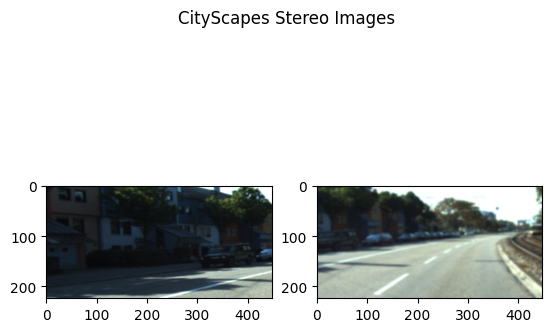

1 <class 'dict'>
torch.Size([3, 224, 448]) torch.Size([3, 224, 448])


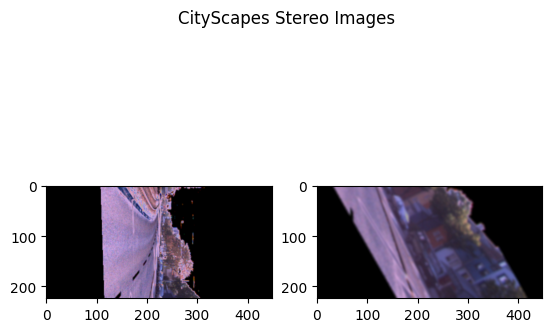

2 <class 'dict'>
torch.Size([3, 224, 448]) torch.Size([3, 224, 448])


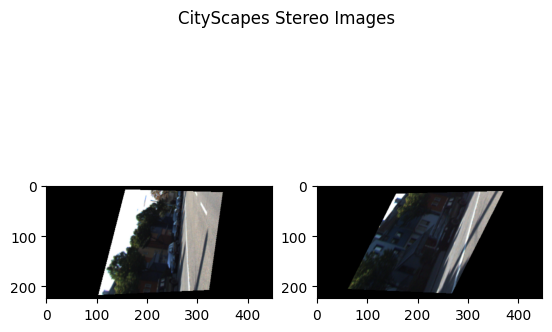

3 <class 'dict'>
torch.Size([3, 224, 448]) torch.Size([3, 224, 448])


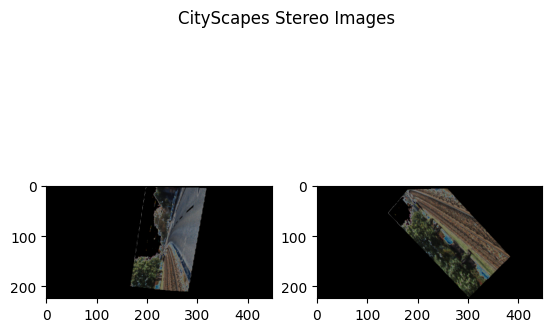

In [10]:
# -------------- Iterate over a few samples ------------
if TESTING=='downstream':
    for i in range(len(train_dataset)):
        if i > 3:
            break
        else:
            # left_image, right_image = dataset[i]
            sample = train_dataset[i]
            # base stereo dataset returns;
            # self.image_list[index] + [self.disparity_list[index]], img1, img2, flow, valid.float()
            image_disp_path_list, left_img, right_img, disp, valid = sample
            print(image_disp_path_list)
            
            left_image= ToArray(left_img)
            right_image= ToArray(right_img)
            disp_map = ToArray(disp)
            valid_map = ToArray(valid.unsqueeze(0))
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
            fig.suptitle('Downstream Stereo Images')
            ax1.imshow(left_image.astype(np.uint8))
            ax2.imshow(right_image.astype(np.uint8))
            ax3.imshow(disp_map, cmap='jet')
            ax4.imshow(valid_map)
            plt.show()
            
            

else:
    for i in range(len(train_dataset)):
        if i > 3:
            break
        else:
            # left_image, right_image = dataset[i]
            sample = train_dataset[i]
            left_image, right_image = sample['left_image'], sample['right_image']
            
            print(i, type(sample))
            print(left_image.size(), right_image.size())
            
            left_img= ToArray(left_image)
            right_img= ToArray(right_image)

            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle('MIM Stereo Images')
            ax1.imshow(left_img)
            ax2.imshow(right_img)
            plt.show()

In [ ]:
print(left_img.max(), left_img.min())

totensor = transforms.ToTensor()

left_imgx = np.asarray(Image.open('/data/stereo_data/fallingthings/fat/single/002_master_chef_can_16k/kitchen_0/000003.left.jpg').convert('RGB'))
right_imgx = np.asarray(Image.open('/data/stereo_data/fallingthings/fat/single/002_master_chef_can_16k/kitchen_0/000003.right.jpg').convert('RGB'))

left_img_t = torch.from_numpy(left_imgx).permute(2, 0, 1).float()
right_img_t = torch.from_numpy(right_imgx).permute(2, 0, 1).float()

print(left_img_t.max(), left_img.min())
